Importando Pacotes...
Dataset: celeba, Objective: B, 
Carregando checkpoint de ./checkpoints/last_checkpoint.pt...
Checkpoint carregado, continuando do step 91000...
[Step 91100] Loss:575.3503 MIG:0.0509 SAP:0.0053 HSIC:0.0558 MaxCorr:9.8716e-01 QuasiOK:False


/tmp/ipykernel_2653821/3324227802.py:230: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({


[Step 91200] Loss:534.1360 MIG:0.0532 SAP:0.0013 HSIC:0.0493 MaxCorr:9.8375e-01 QuasiOK:False
[Step 91300] Loss:803.6371 MIG:0.0487 SAP:0.0025 HSIC:0.0498 MaxCorr:9.7820e-01 QuasiOK:False
[Step 91400] Loss:659.4462 MIG:0.0425 SAP:0.0027 HSIC:0.0529 MaxCorr:9.8859e-01 QuasiOK:False


Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/usr/lib/python3.12/shutil.py", line 796, in rmtree
    onexc(os.rmdir, path, err)
  File "/usr/lib/python3.12/shutil.py", line 764, in onexc
    return onerror(func, path, exc_info)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/shutil.py", line 794, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-od76gyu0'


[Step 91500] Loss:517.9779 MIG:0.0704 SAP:0.0118 HSIC:0.0516 MaxCorr:9.8376e-01 QuasiOK:False
[Step 91600] Loss:550.4177 MIG:0.0397 SAP:0.0026 HSIC:0.0601 MaxCorr:9.8496e-01 QuasiOK:False
[Step 91700] Loss:488.5688 MIG:0.0636 SAP:0.0064 HSIC:0.0557 MaxCorr:9.9046e-01 QuasiOK:False
[Step 91800] Loss:527.1676 MIG:0.0464 SAP:0.0113 HSIC:0.0618 MaxCorr:9.7597e-01 QuasiOK:False
[Step 91900] Loss:515.5570 MIG:0.0592 SAP:0.0012 HSIC:0.0574 MaxCorr:9.8553e-01 QuasiOK:False
[Step 92000] Loss:584.0663 MIG:0.0763 SAP:0.0038 HSIC:0.0531 MaxCorr:9.8218e-01 QuasiOK:False
Checkpoint salvo no step 92000
Log salvo em ./checkpoints/log_beta_VAE.csv
[Step 92100] Loss:527.5969 MIG:0.0513 SAP:0.0066 HSIC:0.0465 MaxCorr:9.8431e-01 QuasiOK:False
[Step 92200] Loss:619.4449 MIG:0.0573 SAP:0.0026 HSIC:0.0564 MaxCorr:9.8318e-01 QuasiOK:False
[Step 92300] Loss:602.0756 MIG:0.0561 SAP:0.0064 HSIC:0.0521 MaxCorr:9.8839e-01 QuasiOK:False
[Step 92400] Loss:500.4366 MIG:0.0687 SAP:0.0118 HSIC:0.0517 MaxCorr:9.8039e-01

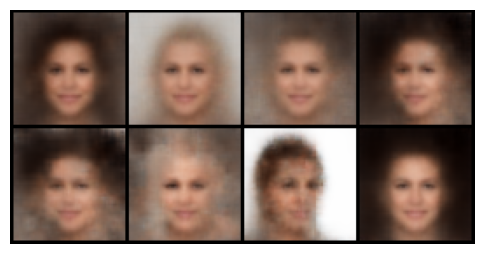

In [1]:
#!/usr/bin/env python
# main.py (atualizado com suporte a Beta-VAE B e H)
# -----------------------------------------
# 1) Data Loading e Argumentos
# -----------------------------------------
import argparse
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
# from utils import compute_hsic, compute_mig, compute_quasi_ortho, compute_sap
import pandas as pd

# Parser de argumentos
parser = argparse.ArgumentParser()
parser.add_argument('--dataset',    type=str,   default='celeba')
parser.add_argument('--dset_dir',   type=str,   default='./data')
parser.add_argument('--seed',       type=int,   default=1)
parser.add_argument('--lr',         type=float, default=5e-4)
parser.add_argument('--beta1',      type=float, default=0.9)
parser.add_argument('--beta2',      type=float, default=0.999)
parser.add_argument('--objective',  type=str,   default='B')  # H ou B
parser.add_argument('--batch_size', type=int,   default=64)
parser.add_argument('--z_dim',      type=int,   default=32)
parser.add_argument('--max_iter',   type=int,   default=100000)
parser.add_argument('--beta',       type=float, default=10)
parser.add_argument('--gamma',      type=float, default=1000.)
parser.add_argument('--C_max',      type=float, default=25.)
parser.add_argument('--C_stop_iter',type=int,   default=1e5)
parser.add_argument('--log_interval', type=int, default=100)
parser.add_argument('--reset', action='store_true')

# utiliza checkpoint salvo se --reset não for especificado
parser.set_defaults(reset=False)

args, _ = parser.parse_known_args()

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'last_checkpoint.pt')

print('Importando Pacotes...')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(args.seed)

transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor(),
])
dataset = datasets.CelebA(root=args.dset_dir, split='all', download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)

# -----------------------------------------
# 2) Modelos Beta-VAE
# -----------------------------------------
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(self.shape)

def reparametrize(mu, logvar):
    std = (logvar * 0.5).exp()
    eps = torch.randn_like(std)
    return mu + eps * std

class BetaVAE(nn.Module):
    def __init__(self, z_dim=32, nc=3):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1), nn.ReLU(True),
            View((-1, 32*4*4)),
            nn.Linear(32*4*4, 256), nn.ReLU(True),
            nn.Linear(256, 256), nn.ReLU(True),
            nn.Linear(256, z_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256), nn.ReLU(True),
            nn.Linear(256, 256), nn.ReLU(True),
            nn.Linear(256, 32*4*4), nn.ReLU(True),
            View((-1, 32, 4, 4)),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 4, 2, 1)
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.z_dim], h[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        return self.decoder(z).view_as(x), mu, logvar

print(f"Dataset: {args.dataset}, Objective: {args.objective}, ")

# -----------------------------------------
# 3) Métricas
# -----------------------------------------
def compute_hsic(z):
    n,d = z.size()
    zc = z - z.mean(0, keepdim=True)
    D = torch.cdist(zc, zc)
    sigma = D.median()
    K = torch.exp(-D**2/(2*sigma**2))
    H = torch.eye(n, device=z.device) - 1/n
    hsic = (K @ H @ K @ H).trace()/((n-1)**2)
    return hsic.item()

def compute_quasi_ortho(z, eps=1e-3):
    Zf = F.normalize(z, p=2, dim=0)
    G = Zf.T @ Zf
    G.fill_diagonal_(0.)
    max_corr = G.abs().max().item()
    return (max_corr <= eps), max_corr

def compute_mig(z_np, factors_np):
    if len(np.unique(factors_np)) > 2:
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        factors_np = est.fit_transform(factors_np)
    n, d = z_np.shape
    _, m = factors_np.shape
    mig_scores = []
    for j in range(m):
        mi = mutual_info_classif(z_np, factors_np[:, j])
        p, counts = np.unique(factors_np[:, j], return_counts=True)
        probs = counts / counts.sum()
        H = -np.sum(probs * np.log(probs + 1e-12))
        if H > 0:
            mi_sorted = np.sort(mi)[::-1]
            mig_scores.append((mi_sorted[0] - mi_sorted[1]) / H)
    return np.mean(mig_scores) if mig_scores else 0.0

def compute_sap(z_np, factors_np, test_size=0.3, random_state=0):
    if len(np.unique(factors_np)) > 2:
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        factors_np = est.fit_transform(factors_np)

    sap_scores = []
    z_dim = z_np.shape[1]

    for j in range(factors_np.shape[1]):
        y = factors_np[:, j]
        if np.unique(y).size < 2:
            continue
        errs = []
        for i in range(z_dim):
            X = z_np[:, i].reshape(-1, 1)
            X_tr, X_te, y_tr, y_te = train_test_split(
                X, y, test_size=test_size, random_state=random_state
            )
            try:
                clf = LogisticRegression(max_iter=1000)
                clf.fit(X_tr, y_tr)
                errs.append(1 - clf.score(X_te, y_te))
            except ValueError:
                continue
        if len(errs) < 2:
            continue
        errs = np.array(errs)
        idx = np.argsort(errs)
        sap_scores.append(errs[idx[1]] - errs[idx[0]])
    return np.mean(sap_scores) if sap_scores else 0.0

# -----------------------------------------
# 4) Training Loop com Objective H ou B
# -----------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BetaVAE(z_dim=args.z_dim, nc=3).to(device)
opt = optim.Adam(model.parameters(), lr=args.lr, betas=(args.beta1, args.beta2))

df = pd.DataFrame(columns=['step', 'loss', 'mig', 'sap', 'hsic', 'max_corr', 'quasi_ok'])

start_step = 1
if os.path.exists(checkpoint_path) and not args.reset:
    print(f"Carregando checkpoint de {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    start_step = checkpoint['step'] + 1

    print(f"Checkpoint carregado, continuando do step {checkpoint['step']}...")

for step in range(start_step, args.max_iter + 1):
    x, attrs = next(iter(data_loader))
    x = x.to(device)
    x_recon, mu, logvar = model(x)
    recon = F.mse_loss(torch.sigmoid(x_recon), x, reduction='sum')/x.size(0)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    if args.objective == 'H':
        loss = recon + args.beta * kld
    elif args.objective == 'B':
        C = min(args.C_max * step / args.C_stop_iter, args.C_max)
        loss = recon + args.gamma * torch.abs(kld - C)

    opt.zero_grad(); loss.backward(); opt.step()

    if step % args.log_interval == 0:
        with torch.no_grad():
            zs = mu.cpu().numpy()
            fac = attrs.numpy()

            mig = compute_mig(zs, fac)
            sap = compute_sap(zs, fac)
            hsic = compute_hsic(mu)
            ok, eps_real = compute_quasi_ortho(mu)

            df = pd.concat([df, pd.DataFrame({
                'step': [step],
                'loss': [loss.item()],
                'mig': [mig],
                'sap': [sap],
                'hsic': [hsic],
                'max_corr': [eps_real],
                'quasi_ok': [ok]
            })], ignore_index=True)

        print(f"[Step {step}] Loss:{loss.item():.4f} MIG:{mig:.4f} SAP:{sap:.4f} "
              f"HSIC:{hsic:.4f} MaxCorr:{eps_real:.4e} QuasiOK:{ok}")

    if step % 1000 == 0 or step == args.max_iter:
        torch.save({
            'step': step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
        }, checkpoint_path)
        df.to_csv(os.path.join(checkpoint_dir, 'log_beta_VAE.csv'), index=False)
        print(f"Checkpoint salvo no step {step}")
        print(f"Log salvo em {os.path.join(checkpoint_dir, 'log_beta_VAE.csv')}")

df.to_csv(os.path.join(checkpoint_dir, 'log_beta_VAE.csv'), index=False)


# print(f"MIG:{mig:.4f} SAP:{sap:.4f} HSIC:{hsic:.4f} MaxCorr:{eps_real:.4e} QuasiOK:{ok}")

# -----------------------------------------
# 5) Sample Generation
# -----------------------------------------
model.eval()
with torch.no_grad():
    z = torch.randn(8, args.z_dim, device=device)
    samples = torch.sigmoid(model.decoder(z)).cpu()
    grid = utils.make_grid(samples, nrow=4, normalize=True)
    plt.figure(figsize=(6,6)); plt.axis('off')
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [2]:
df

,step,loss,mig,sap,hsic,max_corr,quasi_ok
0,91100,575.350281,0.050851,0.005263,0.055830,0.987160,False
1,91200,534.135986,0.053233,0.001282,0.049272,0.983752,False
2,91300,803.637146,0.048737,0.002500,0.049765,0.978197,False
3,91400,659.446228,0.042510,0.002703,0.052887,0.988590,False
4,91500,517.977905,0.070390,0.011842,0.051630,0.983757,False
...,...,...,...,...,...,...,...
85,99600,482.251343,0.071855,0.009459,0.063556,0.986833,False
86,99700,477.959229,0.046776,0.006579,0.069032,0.989958,False
87,99800,705.288330,0.044225,0.006250,0.054041,0.987004,False
88,99900,443.536285,0.056472,0.005714,0.072430,0.980579,False


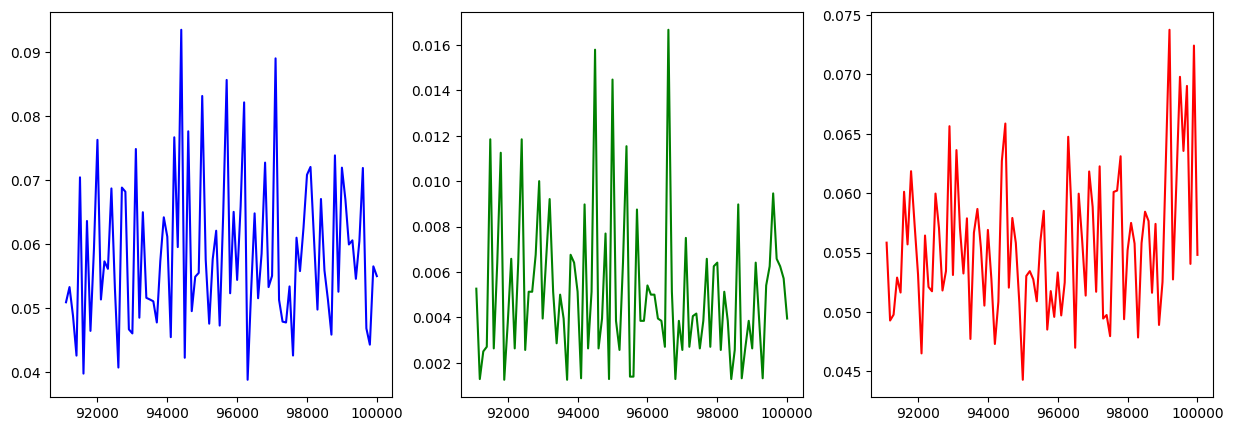

In [6]:
x = df.step.values
fig,ax = plt.subplots(nrows = 1, ncols = 3)
#size of figure
fig.set_size_inches(15, 5)

ax[0].plot(x,df.mig.values,'b')
ax[1].plot(x, df.sap.values, 'g')
ax[2].plot(x,df.hsic.values,'r')


In [ ]:
# salvar umas 10000 imagens para calcular FID
os.makedirs(fake_dir, exist_ok=True)
with torch.no_grad():
    for idx in range(10000 // args.batch_size):
        z = torch.randn(args.batch_size, args.z_dim, device=device)
        imgs = torch.sigmoid(model.decoder(z)).cpu()
        for j in range(imgs.size(0)):
            utils.save_image(imgs[j], os.path.join(fake_dir, f"{idx*args.batch_size + j:04d}.png"))
# aí calcula
fid_final = compute_fid(real_dir, fake_dir)
print(f"FID final (fake vs real): {fid_final:.2f}")
